In [ ]:
! pip install transformers==4.40.1 # Use this version and Python==3.10 for stable compatibility

In [ ]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
from transformers import AutoModelForCausalLM

In [ ]:
# load model and dataset
model = AutoModelForCausalLM.from_pretrained('thuml/timer-base-84m', trust_remote_code=True)
df = pd.read_csv("https://raw.githubusercontent.com/WenWeiTHU/TimeSeriesDatasets/refs/heads/main/ETT-small/ETTh2.csv")

In [ ]:
# perpare input
lookback_length = 1440      # support the maximum context length up to 2880 
seqs = torch.tensor(df["OT"][:lookback_length]).unsqueeze(0).float()
mean, std = seqs.mean(dim=-1, keepdim=True), seqs.std(dim=-1, keepdim=True)     # normalize the input to mitigate the scale effect
normed_seqs = (seqs - mean) / std

In [ ]:
# generate forecast 
prediction_length = 288     # forecast the next 288 timestamps, supporting maximum prediction length encompassed in the context length
normed_output = model.generate(normed_seqs, max_new_tokens=prediction_length)
output = std * normed_output + mean                                             # rescale the output to the original scale

In [250]:
print(output.shape)

torch.Size([1, 288])


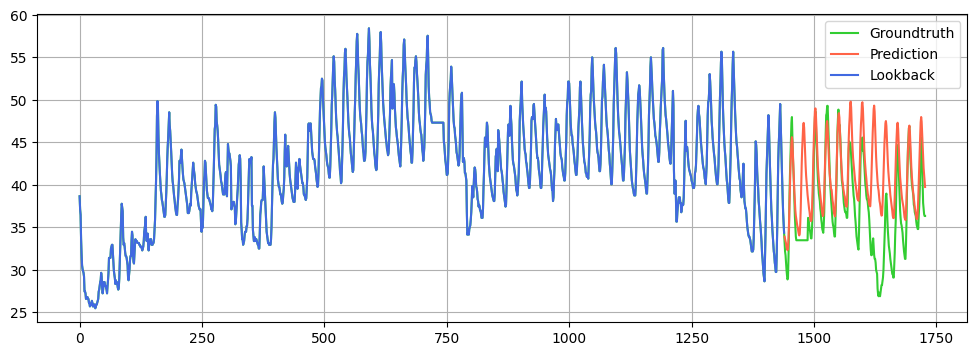

In [ ]:
# plot the prediction

plt.figure(figsize=(12, 4))
plt.plot(df["OT"][:lookback_length + prediction_length], color="limegreen", label="Groundtruth")
plt.plot(range(lookback_length, lookback_length + prediction_length), output[0], color="tomato", label="Prediction")
plt.plot(df["OT"][:lookback_length], color="royalblue", label="Lookback")
plt.legend()
plt.grid()
plt.show()